# Initialization

We will be using PyTorch for our neural network and the Labelled Faces in the Wild dataset.

In [ ]:
import tarfile
import torch
import torchvision as tv
import numpy as np
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -nv
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt -nv
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt -nv
!wget http://vis-www.cs.umass.edu/lfw/pairs.txt -nv

tfile = tarfile.open("lfw-deepfunneled.tgz", "r:gz")
tfile.extractall("lfw_home/.")

!mv lfw_home/lfw-deepfunneled lfw_home/lfw_funneled
!mv pairsDevTrain.txt lfw_home/.
!mv pairsDevTest.txt lfw_home/.
!mv pairs.txt lfw_home/.

2023-02-17 19:31:41 URL:http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz [108761145/108761145] -> "lfw-deepfunneled.tgz" [1]
2023-02-17 19:31:41 URL:http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt [56579/56579] -> "pairsDevTrain.txt" [1]
2023-02-17 19:31:41 URL:http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt [26002/26002] -> "pairsDevTest.txt" [1]
2023-02-17 19:31:42 URL:http://vis-www.cs.umass.edu/lfw/pairs.txt [155335/155335] -> "pairs.txt" [1]


In [ ]:
""" Helper function to plot a gallery of labeled numbers """
def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    plt.figure(figsize=(2 * n_col, 2.6 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.25)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(()) #remove tick marks
        plt.yticks(())

Switching to a GPU allows you to speed up processing dramatically. 

Use .to(device="cuda") to send data or operations to the GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using: {device}")

Using: cuda


In [ ]:
batch_size = 64

# Prepare dataset

In [ ]:
# Read the data from disk and load it as numpy arrays
lfw = fetch_lfw_people(
    min_faces_per_person=5, resize=0.5, data_home=".", download_if_missing=False
)

# Transform data to tensors
# Divide by brightest pixel (max), this brings all values to range [0, 1]
for i in range(len(lfw.images)):
    lfw.data[i] /= lfw.data[i].max()

lfw_batches = torch.utils.data.DataLoader(
    lfw.data, batch_size=batch_size, shuffle=True, drop_last=True
)

# Create the generator and discriminator

The generator generates an image from latent space (chosen to be 128 dimensions/pixels).

The discriminator decides whether an image is real or has been generated, and is trained on both real and generated images.

We send both of these to the GPU; this is where much of the intensive processing happens

In [ ]:
pixels = 2914
latent = 128

# Generate a 62x47 image (2914 pixels) from a latent space of 128
generator = torch.nn.Sequential(
    torch.nn.Linear(latent, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, pixels)
).to(device)

# Dropout randomly zeroes some elements in the input tensor w/probability p
# This improves neural nets, prevents co-adaptation of neurons and overfitting
discriminator = torch.nn.Sequential(
    torch.nn.Linear(pixels, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 1),
    torch.nn.Sigmoid()
).to(device)

# Start training the GAN

We will use binary cross entropy for our loss function and ADAM for our optimizer. I found ADAM worked better than stochastic gradient descent. SGD tended to fluctuate more at the bottom, and it wasn't able to find as low of a loss as ADAM was. With ADAM, I consistently got to 0.69, while SGD hovered around 0.90.

- On the run pictured here, the error was around 1, but I got similar or even better faces than when the error was in the .70 range.

Since our labels are zeros or ones, it's easiest and best to declare them before training, as they won't change at all.

In [ ]:
loss_fn = torch.nn.BCELoss()

lr = 0.0005
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr)
optimizer_generator =     torch.optim.Adam(generator.parameters(), lr)

real_labels =      torch.ones ((batch_size, 1)).to(device)
generated_labels = torch.zeros((batch_size, 1)).to(device)
all_labels = torch.cat((real_labels, generated_labels))

In training, I found that training both the discriminator and the generator at once produced better results than training them separately.

I would like to try to get convolutional layers going in my models, but I'm not sure I'll be able to figure that out in time.

Again, we send the data to the GPU for faster processing.

In [ ]:
print(f"Epoch\t\tDiscrim. Loss\tGenerator Loss")
for epoch in range(100):
    total_loss_d = 0
    total_loss_g = 0

    for real_samples in lfw_batches:
        real_samples = real_samples.to(device)

        # Data for training the discriminator
        latent_space_samples = torch.randn((batch_size, latent)).to(device)

        generator.zero_grad()
        generated_samples = generator(latent_space_samples)

        all_samples = torch.cat((real_samples, generated_samples))


        # Train the discriminator on both types
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_fn(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Track loss
        total_loss_d += loss_discriminator.item()



        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, latent)).to(device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        
        loss_generator = loss_fn(discriminator(generated_samples), real_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Track loss
        total_loss_g += loss_generator.item()

    # Show loss
    if epoch % 10 == 0:
        print(f"{epoch: 3}\t\t{total_loss_d/batch_size:.4f}\t\t{total_loss_g/batch_size:.4f}")

Epoch		Discrim. Loss	Generator Loss
  0		0.6191		1.5786
 10		0.6817		2.3317
 20		0.6598		3.2664
 30		0.7856		2.1957
 40		0.9146		1.5878
 50		0.8902		1.7736
 60		0.4608		3.2741
 70		1.0086		0.9973
 80		1.0082		1.0137
 90		1.0074		1.0094


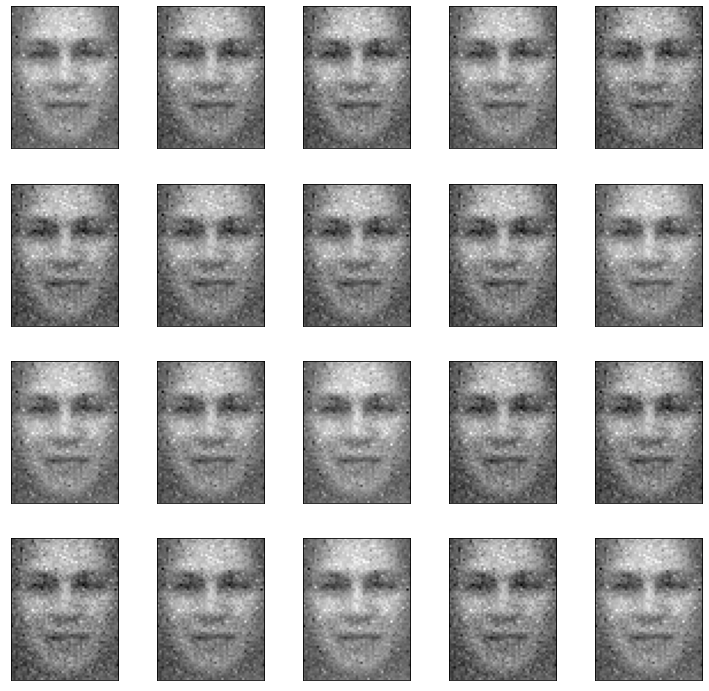

In [ ]:
example_faces = np.array([
    generated_samples[i].cpu().detach().numpy().reshape(62,47) 
    for i in range(20)])

plot_gallery(example_faces, [""]*20, 62, 47, 4)

Though the faces all look very similar, you can see some variation in them. There's a good amount of detail, so if I found a way to reduce the noise, I think these would look really good. That's why I'm going to try to get the convolutional layers working.